# **Deep Learning Group Project: Eye Disease Classification**
**Master's  Degree Program in Data Science and Advanced Analytics, with a specialization in Data Science (A.Y. 2022/2023)**<br/>
**NOVA IMS**<br/>


### **Group Information**

*   André Cunha, 20191224 - r20191224@novaims.unl.pt
*   Catarina Duarte, 20191211 - r20191211@novaims.unl.pt
*   Cláudia Rocha, 20191249 - r20191249@novaims.unl.pt
*   Dinis Melo, 20191190 - r20191190@novaims.unl.pt
*   Susana Dias, 20220198 - 20220198@novaims.unl.pt

### **Data Source** 

Kaggle dataset:
https://www.kaggle.com/datasets/gunavenkatdoddi/eye-diseases-classification


Link to the prepared dataset: https://drive.google.com/drive/folders/1HEti1Qv_-iXiOf2zp2amG8XFgk-HPuLj?usp=sharing

### **Main Steps** 


*   For each of our best models conduct a hyperpameter search 
*   Run the best models with the hyperparameters achieved 
*   Compare te results of the original models vs the hypertuned

# **Import the Needed Libraries**

In [1]:
!pip install -q -U keras-tuner

# Imports
import tensorflow as tf
from tensorflow.keras import datasets
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential, layers, initializers, regularizers, optimizers, metrics 
from keras.models import Model
from keras.layers import Dense, Conv2D
from tensorflow.keras import regularizers
import keras_tuner as kt
from tensorflow.keras.initializers import GlorotNormal


from sklearn.metrics import confusion_matrix

import os
import time
import shutil
import random 
import zipfile

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.colors import ListedColormap


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.2/172.2 KB 2.8 MB/s eta 0:00:00


# **Needed Code**



We are repeating the same pre-processing steps from previous notebooks with the same seed to perserved the worked on data division. 

In [2]:
# Set the machine
gdrive = True
# Set the connection string
path = "/content/drive/MyDrive/Deep Learning/Projeto DL/"
main_folder, training_folder, testing_folder = "dataset_prepared/", "train/", "test/"
# If using Google Drive
if gdrive:
    # Setup drive
    from google.colab import drive
    drive.mount('/content/drive')        
    # Transfer zip dataset to the current virtual machine
    t0 = time.time()
    shutil.copyfile(path + 'dataset_prepared.zip', 'dataset_prepared.zip')
    # Extract files
    zip_ = zipfile.ZipFile('dataset_prepared.zip')
    zip_.extractall()
    zip_.close()
    print("File transfer completed in %0.3f seconds" % (time.time() - t0))
    path = ""

Mounted at /content/drive
File transfer completed in 12.864 seconds


In [3]:
image_size=(128, 128)
crop_to_aspect_ratio=True
color_mode='rgb'
batch_size=64
label_mode="categorical"
validation_split=0.2
shuffle=True
seed=0

In [4]:
# Generate an object of type tf.data.Dataset 
ds_train, ds_val = image_dataset_from_directory(path + main_folder + training_folder, 
                                                image_size=image_size,
                                                crop_to_aspect_ratio=crop_to_aspect_ratio,
                                                color_mode=color_mode,
                                                batch_size=batch_size,
                                                labels='inferred',
                                                label_mode=label_mode,
                                                subset='both',
                                                validation_split=validation_split, 
                                                shuffle=shuffle,
                                                seed=seed)
# Check object properties
print("\nObject's type:\t", type(ds_train))
print("Is it a tf.data.Dataset?\t R:",isinstance(ds_train, tf.data.Dataset))
print("Classes:", ds_train.class_names)

Found 3373 files belonging to 4 classes.
Using 2699 files for training.
Using 674 files for validation.

Object's type:	 <class 'tensorflow.python.data.ops.batch_op._BatchDataset'>
Is it a tf.data.Dataset?	 R: True
Classes: ['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']


In [5]:
iter_train = iter(ds_train)
batch_x_train, batch_y_train = iter_train.next()

In [6]:
ds_test = image_dataset_from_directory(path + main_folder + testing_folder, 
                                       image_size=image_size,
                                       crop_to_aspect_ratio=crop_to_aspect_ratio,
                                       color_mode=color_mode,
                                       batch_size=batch_size,
                                       label_mode=label_mode,                                     
                                       shuffle=shuffle,
                                       seed=seed)

Found 844 files belonging to 4 classes.


# **Functions**

We defined the functions used in the previous notebooks to compile the model and analize the results

In [7]:

def compile_model(model, learning_rate = 0.001):
    model.compile(loss="categorical_crossentropy",
                  optimizer=optimizers.RMSprop(learning_rate=learning_rate),
                  metrics=[metrics.CategoricalAccuracy(name='accuracy'),
                          ])

In [8]:
def plot_training_history(history):
    df_hist = pd.DataFrame.from_dict(history.history)
    df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)

    fig, axs = plt.subplots(1, 2, figsize=(16, 4))

    # Plot loss curves
    ax1 = df_hist.plot(x="Epoch", y=['loss', 'val_loss'],
                       kind="line", grid=True, legend=True,
                       ylabel="Categorical cross-entropy", 
                       xlabel="Epoch", title="Loss curves",                  
                       color=['darkred', 'indianred'], alpha=0.75, fontsize=10, ax=axs[0])
    ax1.legend(loc=(0, -0.45), framealpha = 1.0)
    ax1.set_ylim([0, 1])

    # Plot accuracy curves
    ax2 = df_hist.plot(x="Epoch", y=['accuracy', 'val_accuracy'],
                       kind="line", grid=True, legend=True,
                       ylabel="Accuracy", 
                       xlabel="Epoch", title="Accuracy curves",                  
                       color=['darkblue', 'royalblue','green'], alpha=0.75, fontsize=10, ax=axs[1])
    ax2.legend(loc=(0, -0.45), framealpha=1.0)
    ax2.set_ylim([0, 1])

  

# **Data Preprocessing**


In [9]:
preprocessing = Sequential([layers.Rescaling(1./255)], name="preprocessing")

In [10]:
input_shape = tuple(batch_x_train.shape)


# **Best Models**

Having in mind all that was explaind in the previous notebook of *Preprocess&modeling*, we imported our two best models to hypertune them, ``Model V1`` and ``Model V1.8``

The process of Hyperparameter Tuning corresponds to the search of the best hyperparameters for that spcific architecture of deep learning model so that the model achives the best performance, this is, higher accuracy and smaller loss.


## **Models V1**

In [11]:
modelv1 = Sequential([
                    layers.Input(input_shape[1:]),
                    preprocessing,
                    
                    layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
                    layers.MaxPooling2D(pool_size=(2, 2)),

                    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
                    layers.MaxPooling2D(pool_size=(2, 2)),

                    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
                    layers.MaxPooling2D(pool_size=(2, 2)),

                    layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
                    layers.MaxPooling2D(pool_size=(2, 2)),

                    layers.Flatten(),

                    layers.Dense(units=128, activation='relu'),
                    layers.Dense(units=4, activation='softmax')

                    ])

## **Models V1.8**

In [12]:
modelv1_8 = Sequential([
    layers.Input(input_shape[1:]),
    preprocessing,

    layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Flatten(),

    layers.Dense(units=256, activation='relu', kernel_regularizer=regularizers.L2(1e-5),
                               bias_regularizer=regularizers.L2(1e-4)),
    layers.Dropout(0.5),
    layers.Dense(units=4, activation='softmax', kernel_regularizer=regularizers.L2(1e-5),
                               bias_regularizer=regularizers.L2(1e-4))
])

# **HyperParameter Search**

## **Model V1**

We have defined `Model V1` once again, but this time it is ready to be hypertuned. The main difference from the previously defined model is that this function takes a parameter `hp`, which corresponds to the hyperparameters that will be tested with various possible values in order to achieve the best performance. The explored parameters will be described later.



In [13]:
def build_model_1(hp):
  model = Sequential([
    layers.Input((input_shape[1:])),
    preprocessing,

    #1st layer
    layers.Conv2D(filters=hp.Int('conv_1_filter', min_value=32, max_value=64, step=16)
                    ,kernel_size=(3, 3), activation='relu'),

    layers.MaxPooling2D(pool_size=(2, 2)),

    #2nd layer
    layers.Conv2D(filters=hp.Int('conv_2_filter', min_value=64, max_value=128, step=16)
                    ,kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    #3nd layer
    layers.Conv2D(filters=hp.Int('conv_3_filter', min_value=64, max_value=256, step=16)
                    ,kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    #4nd layer
    layers.Conv2D(filters=hp.Int('conv_4_filter', min_value=128, max_value=512, step=16)
                    ,kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Flatten(),

    layers.Dense(units=hp.Int('units', min_value=128, max_value=256, step=16), 
                 activation='relu', 
                 kernel_regularizer=regularizers.L2(1e-5),
                 bias_regularizer=regularizers.L2(1e-4)),

    layers.Dropout(hp.Choice('dropout_rate',values=[0.2,0.5])), #    layers.Dropout(0.5),

   layers.Dense(units=4, activation='softmax', kernel_regularizer=regularizers.L2(hp.Choice('kernel_regularizer', values=[1e-4, 1e-5, 1e-6])),
                               bias_regularizer=regularizers.L2(hp.Choice('bias_regularizer', values=[1e-4, 1e-5, 1e-6])))
 ])

  model.compile( loss='categorical_crossentropy',
                optimizer= optimizers.RMSprop(hp.Choice('learning_rate', values=[1e-2, 1e-3])), 
                metrics= metrics.CategoricalAccuracy(name='accuracy'))

  return model

To set our hyperparamenter seacher for Model V1, we will define a tuner that executes a random search from the kerastuner library on `build_model_1`.The random part is due to the seacrh being runned on random samplind and the search because several values of the hyperparamenters will be tested. 

We defined as the objective metric that the tuner will based its evalutation for the different hyperparameters. In our case, we opted for the `minimization of the validation loss`. This means that, for the tuner to conclude that one set of hyperparameters are better than other, it will be based on the minimization of the validation loss and select the set of hyperparameters that produces the lowest validation loss.  

We defined that the same model will only be trained one time with different hyperparameters and it will try maximum 8 different combinations.

Our keras tuner performed a random search over the following hyperparameters for the model V1:

> *   For `conv_1_filter` the number of filters in the first convolutional layer with the values ranging from 32 to 64 with step size 16, this is, the absolute value that a hyperparameter varies during the search process;

>*   For `conv_2_filter` the number of filters in the second convolutional layer with the values ranging from 64 to 128 with step size 16;

>*   For `conv_3_filter` the number of filters in the third convolutional layer with the values ranging from 64 to 256 with step size 16;

>*   For `conv_4_filter` the number of filters in the fourth convolutional layer with the values ranging from 128 to 512 with step size 16;

>* The number `units`  in the dense layer with values ranging from 128 to 256 with step size 16;

>* The `dropout_rate`, which corresponds to the probability that a given neuron in our model will be randomly "dropped out" during training, testing it with 0.2 or 0.5;

>* For `kernel_regularizer`, seeing that we are using a L2 regularization,   the weight given to the sum of the squares of the weights in the loss function, testing this paramenter with 1e-4, 1e-5 and 1e-6;

>* The `bias_regularizer`, also using a L2 regularization,  the magnitude of the  penalty that is applied to the biases of the model during training testing this paramenter with 1e-4, 1e-5 and 1e-6;

>* The `learning_rate` for the RMSprop optimizer testing it with 0.01 and 0.001.



In [14]:
tuner_v1 = kt.RandomSearch(build_model_1,
                          objective='val_loss', 
                          directory="my_first_keras_tuner",
                          overwrite=True,                        
                          executions_per_trial=1, 
                          max_trials=8,
                          seed=seed)

With the tuner ready to be used on Model V1, we will conduct the search by defining it to train and validate for 10 epochs in order to find the best set of hyperparameters.

In [15]:
tuner_v1.search(ds_train, epochs=10, validation_data = ds_val)

Trial 8 Complete [00h 03m 06s]
val_loss: 0.7855786681175232

Best val_loss So Far: 0.6529542207717896
Total elapsed time: 00h 26m 05s


In [16]:
tuner_results = tuner_v1.results_summary()

print(tuner_results)

Results summary
Results in my_first_keras_tuner/untitled_project
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 5 summary
Hyperparameters:
conv_1_filter: 64
conv_2_filter: 112
conv_3_filter: 96
conv_4_filter: 496
units: 192
dropout_rate: 0.2
kernel_regularizer: 1e-06
bias_regularizer: 1e-06
learning_rate: 0.01
Score: 0.6529542207717896

Trial 2 summary
Hyperparameters:
conv_1_filter: 48
conv_2_filter: 64
conv_3_filter: 112
conv_4_filter: 432
units: 240
dropout_rate: 0.2
kernel_regularizer: 1e-06
bias_regularizer: 1e-06
learning_rate: 0.01
Score: 0.6887540817260742

Trial 6 summary
Hyperparameters:
conv_1_filter: 64
conv_2_filter: 80
conv_3_filter: 128
conv_4_filter: 160
units: 176
dropout_rate: 0.2
kernel_regularizer: 1e-05
bias_regularizer: 1e-05
learning_rate: 0.01
Score: 0.7034980058670044

Trial 7 summary
Hyperparameters:
conv_1_filter: 32
conv_2_filter: 112
conv_3_filter: 176
conv_4_filter: 304
units: 176
dropout_rate: 0.2
kernel_regularizer: 1e-05
bias_

In the code above it was displayed the results of the best trials with their respective hyperparetes runnned.

Based on the validadtion loss, the Keras tuner found that the best set of hyperparameters were the inde used in `Trial 5` with a validation loss of **0.6530**, and it used the following hyperparameters:  

*   *conv_1_filter*=**64**;
*   *conv_2_filter*=**112**;
*  *conv_3_filter*=**96**;
* *conv_4_filter*=**496**;
*  *units*=**192**;
* *dropout_rate*=**0.2**;
* *kernel_regularizer*=**1e-06**;
* *bias_regularizer*=**1e-06**;
* and *learning_rate*=**0.01**.

Using the best performing set of hyperparamerter showed above, we are now going to train our Model V1 for 10 epochs.


In [17]:
# Train the model with the best hyperparameters
best_model_v1_hp = tuner_v1.get_best_models(num_models=1)[0]
best_hyperparameters_v1 = tuner_v1.get_best_hyperparameters(num_trials=1)[0]

history_best_model_v1_hp = best_model_v1_hp.fit(ds_train, epochs=10, validation_data= ds_val)

Epoch 1/10
43/43 [==============================] - 21s 368ms/step - loss: 0.6950 - accuracy: 0.6947 - val_loss: 0.8850 - val_accuracy: 0.5341
Epoch 2/10
43/43 [==============================] - 18s 371ms/step - loss: 0.9679 - accuracy: 0.6636 - val_loss: 0.7950 - val_accuracy: 0.5282
Epoch 3/10
43/43 [==============================] - 19s 382ms/step - loss: 0.6421 - accuracy: 0.7051 - val_loss: 0.7018 - val_accuracy: 0.7018
Epoch 4/10
43/43 [==============================] - 18s 368ms/step - loss: 0.6488 - accuracy: 0.7066 - val_loss: 1.7998 - val_accuracy: 0.4184
Epoch 5/10
43/43 [==============================] - 18s 365ms/step - loss: 0.7280 - accuracy: 0.6980 - val_loss: 0.8666 - val_accuracy: 0.5371
Epoch 6/10
43/43 [==============================] - 19s 372ms/step - loss: 0.6819 - accuracy: 0.6954 - val_loss: 0.6642 - val_accuracy: 0.7359
Epoch 7/10
43/43 [==============================] - 18s 372ms/step - loss: 0.6861 - accuracy: 0.7151 - val_loss: 1.0067 - val_accuracy: 0.6380

### **Compare ``best_modelv1_hp`` with the original model**

In order to compare the results of the Model V1, before and after hypertuning we are going to run the original model without the aid of the tuner.


In [18]:
compile_model(modelv1)

In [19]:
history_modelv1 = modelv1.fit(ds_train, epochs=10, validation_data= ds_val)

Epoch 1/10
43/43 [==============================] - 20s 371ms/step - loss: 1.3426 - accuracy: 0.3764 - val_loss: 1.1893 - val_accuracy: 0.4718
Epoch 2/10
43/43 [==============================] - 20s 389ms/step - loss: 1.1220 - accuracy: 0.5120 - val_loss: 1.2437 - val_accuracy: 0.4006
Epoch 3/10
43/43 [==============================] - 18s 376ms/step - loss: 0.9106 - accuracy: 0.6228 - val_loss: 1.1599 - val_accuracy: 0.4941
Epoch 4/10
43/43 [==============================] - 19s 391ms/step - loss: 0.7667 - accuracy: 0.6732 - val_loss: 0.7497 - val_accuracy: 0.6513
Epoch 5/10
43/43 [==============================] - 17s 352ms/step - loss: 0.6109 - accuracy: 0.7573 - val_loss: 0.5466 - val_accuracy: 0.7834
Epoch 6/10
43/43 [==============================] - 17s 359ms/step - loss: 0.5557 - accuracy: 0.7814 - val_loss: 0.5345 - val_accuracy: 0.7611
Epoch 7/10
43/43 [==============================] - 19s 387ms/step - loss: 0.5076 - accuracy: 0.7984 - val_loss: 0.5392 - val_accuracy: 0.7938

For a better comparison of the metrics between the original and hypertuned models of V1, we are going to plot the previously used loss and accuracy curves.




#### **Original model**

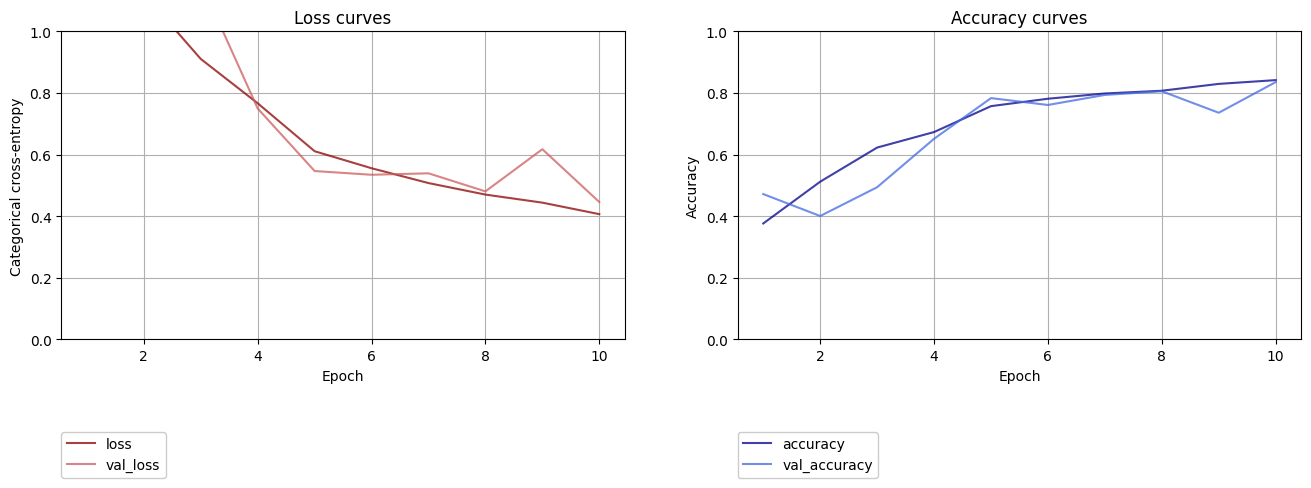

In [20]:
plot_training_history(history_modelv1)

#### **Hyperparameter model**

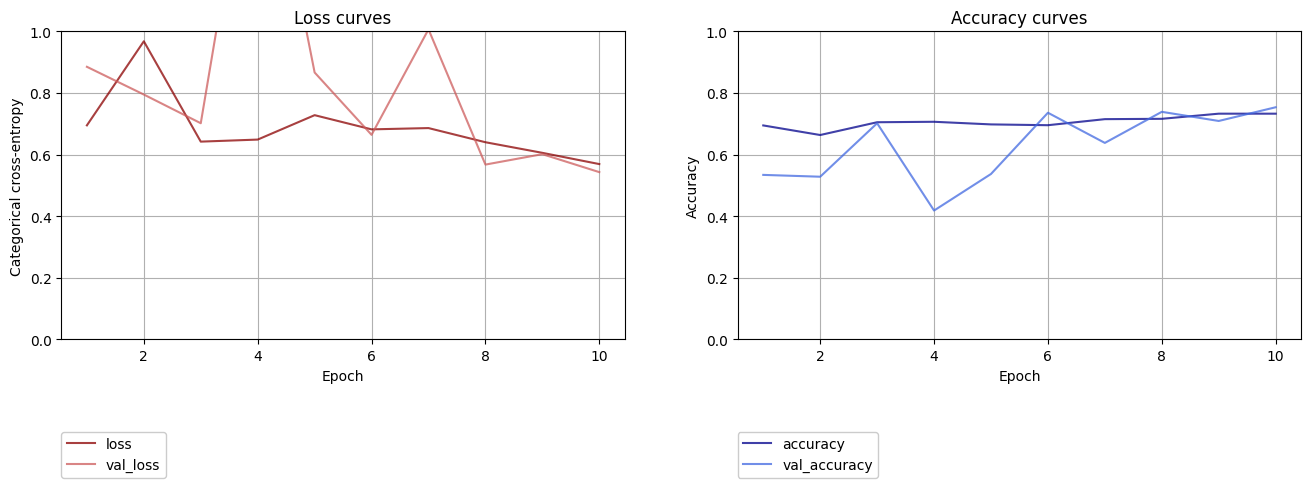

In [21]:
plot_training_history(history_best_model_v1_hp)

The *original model* has an ``accuracy`` value of 0.8418 and a ``validation accuracy`` value of 0.8353, while the *hyper tuned* model has an ``accuracy`` value of 0.7329 and a ``validation accuracy`` value of 0.7537. These values mean that our hyper tuned model did not performed better that our original model. This may have happen due to the hyper parameters be overfitting the data or not be the most suited for our model.


Nevertheless, the results achieved with the original model are quite satisfying seeing that the values are quite high, while close to each other, this is, it does not overfit and has the ability to adapt to new and unseen data. Overall, it is important to notice that this doesn't mean that any hypertuning of the original model would fail, but our specific hypertunning process was not the most suitable for this problem. If given the chance, we would have tried other values and hypothesis.

## **Model V1.8**

For the HyperTunning of model V1.8, we are going to follow the same steps as the previous model. Starting by defining the Model V1.8 ready to be hypertuned.

In [22]:
def build_model_1_8(hp):
  model = Sequential([
    layers.Input((input_shape[1:])),
    preprocessing,

    layers.Conv2D(filters=hp.Int('conv_1_filter', min_value=32, max_value=128, step=16)
                    ,kernel_size=(3, 3), activation='relu'),

    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(filters=hp.Int('conv_2_filter', min_value=32, max_value=128, step=16)
                    ,kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Flatten(),

    layers.Dense(units=hp.Int('units', min_value=128, max_value=256, step=16), 
                 activation='relu', 
                 kernel_regularizer=regularizers.L2(1e-5),
                 bias_regularizer=regularizers.L2(1e-4)),

    layers.Dropout(hp.Choice('dropout_rate', values=[0.2,0.5])), #    layers.Dropout(0.5),


   
    layers.Dense(units=4, activation='softmax', kernel_regularizer=regularizers.L2(hp.Choice('kernel_regularizer', values=[1e-4, 1e-5, 1e-6])),
                               bias_regularizer=regularizers.L2(hp.Choice('bias_regularizer', values=[1e-4, 1e-5, 1e-6])))
])

  model.compile( loss='categorical_crossentropy',
                optimizer= optimizers.RMSprop(hp.Choice('learning_rate', values=[1e-2, 1e-3])), 
                metrics= metrics.CategoricalAccuracy(name='accuracy'))

  return model

Like before, to set our hyperparamenter seacher for Model V1.8, we will define a tuner that executes a random search from the kerastuner library on `build_model_1_8`. We kept the same parameters of the tuner as before.

Our keras tuner performed a random search over the following hyperparameters for the model V1.8:

> *   For `conv_1_filter` the number of filters in the first convolutional layer with the values ranging from 32 to 128 with step size 16, this is, the absolute value that a hyperparameter varies during the search process.

>*   For `conv_2_filter` the number of filters in the second convolutional layer that is used in a block with the values ranging from 32 to 128 with step size 16.

>* The number `units`  in the dense layer with values ranging from 128 to 256 with step size 16.

>* The `dropout_rate`, which corresponds to the probability that a given neuron in our model will be randomly "dropped out" during training, testing it with 0.2 or 0.5;

>* For `kernel_regularizer`, seeing that we are using a L2 regularization,   the weight given to the sum of the squares of the weights in the loss function, testing this paramenter with 1e-4, 1e-5 and 1e-6;

>* The `bias_regularizer`, also using a L2 regularization,  the magnitude of the  penalty that is applied to the biases of the model during training testing this paramenter with 1e-4, 1e-5 and 1e-6;

>* The `learning_rate` for the RMSprop optimizer testing it with 0.01 and 0.001.



In [23]:
tuner_v1_8 = kt.RandomSearch(build_model_1_8,
                          objective='val_loss', 
                          directory="my_first_keras_tuner",
                          overwrite=True,                        
                          executions_per_trial=1, 
                          max_trials=8,
                          seed=seed)

With the tuner ready to be used on Model V1.8, we will conduct the search by defining it to train and validate for 10 epochs in order to find the best set of hyperparameters.

In [24]:
tuner_v1_8.search(ds_train, epochs=10, validation_data = ds_val)

Trial 8 Complete [00h 03m 13s]
val_loss: 0.5675259828567505

Best val_loss So Far: 0.4704165458679199
Total elapsed time: 00h 26m 47s


In [25]:
tuner_results2 = tuner_v1_8.results_summary()
# Printing the tuner results
print(tuner_results2)

Results summary
Results in my_first_keras_tuner/untitled_project
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 4 summary
Hyperparameters:
conv_1_filter: 80
conv_2_filter: 32
units: 144
dropout_rate: 0.2
kernel_regularizer: 0.0001
bias_regularizer: 1e-05
learning_rate: 0.001
Score: 0.4704165458679199

Trial 6 summary
Hyperparameters:
conv_1_filter: 96
conv_2_filter: 112
units: 128
dropout_rate: 0.2
kernel_regularizer: 1e-06
bias_regularizer: 1e-06
learning_rate: 0.001
Score: 0.5422559976577759

Trial 7 summary
Hyperparameters:
conv_1_filter: 96
conv_2_filter: 80
units: 224
dropout_rate: 0.5
kernel_regularizer: 1e-06
bias_regularizer: 1e-06
learning_rate: 0.001
Score: 0.5675259828567505

Trial 0 summary
Hyperparameters:
conv_1_filter: 112
conv_2_filter: 64
units: 192
dropout_rate: 0.5
kernel_regularizer: 0.0001
bias_regularizer: 0.0001
learning_rate: 0.001
Score: 0.6539904475212097

Trial 5 summary
Hyperparameters:
conv_1_filter: 32
conv_2_filter: 32
units: 12

In the code above it was displayed the results of the best trials with their respective hyperparetes runnned.

Based on the validadtion loss, the Keras tuner found that the best set of hyperparameters were the inde used in `Trial 4` with a validation loss of **0.4704**, and it used the following hyperparameters:  

*   *conv_1_filter*=**80**;
*   *conv_2_filter*=**32**;
*  *units*=**144**;
* *dropout_rate*=**0.2**;
* *kernel_regularizer* = **0.0001**;
* *bias_regularizer*=**1e-05**;
* and *learning_rate*=**0.001**.

Using the best performing set of hyperparamerter showed above, we are now going to train our Model V1.8 for 10 epochs.


In [26]:
# Train the model with the best hyperparameters
best_model_v1_8_hp = tuner_v1_8.get_best_models(num_models=1)[0]
best_hyperparameters_v1_8 = tuner_v1.get_best_hyperparameters(num_trials=1)[0]

history_best_model_v1_8_hp = best_model_v1_8_hp.fit(ds_train, epochs=10, validation_data= ds_val)

Epoch 1/10
43/43 [==============================] - 20s 369ms/step - loss: 0.4544 - accuracy: 0.8214 - val_loss: 0.5983 - val_accuracy: 0.7953
Epoch 2/10
43/43 [==============================] - 19s 406ms/step - loss: 0.3969 - accuracy: 0.8474 - val_loss: 0.5530 - val_accuracy: 0.7893
Epoch 3/10
43/43 [==============================] - 20s 399ms/step - loss: 0.3870 - accuracy: 0.8529 - val_loss: 0.4627 - val_accuracy: 0.8190
Epoch 4/10
43/43 [==============================] - 20s 421ms/step - loss: 0.3462 - accuracy: 0.8688 - val_loss: 0.4084 - val_accuracy: 0.8294
Epoch 5/10
43/43 [==============================] - 24s 516ms/step - loss: 0.3260 - accuracy: 0.8807 - val_loss: 0.4091 - val_accuracy: 0.8546
Epoch 6/10
43/43 [==============================] - 17s 365ms/step - loss: 0.2955 - accuracy: 0.8885 - val_loss: 0.4583 - val_accuracy: 0.8338
Epoch 7/10
43/43 [==============================] - 18s 381ms/step - loss: 0.2684 - accuracy: 0.8951 - val_loss: 0.7507 - val_accuracy: 0.7300

### **Compare ``best_modelv1_hp`` with the original model**

In order to compare the hypertuned and orignal model v1.8 we are going to compile the original.

In [27]:
compile_model(modelv1_8)

In [28]:
history_modelv1_8 = modelv1_8.fit(ds_train, epochs=10, validation_data= ds_val)

Epoch 1/10
43/43 [==============================] - 21s 367ms/step - loss: 1.3984 - accuracy: 0.2808 - val_loss: 1.3874 - val_accuracy: 0.2507
Epoch 2/10
43/43 [==============================] - 20s 423ms/step - loss: 1.3231 - accuracy: 0.3876 - val_loss: 1.1462 - val_accuracy: 0.5000
Epoch 3/10
43/43 [==============================] - 20s 414ms/step - loss: 1.1106 - accuracy: 0.4957 - val_loss: 1.0289 - val_accuracy: 0.4985
Epoch 4/10
43/43 [==============================] - 18s 360ms/step - loss: 1.0022 - accuracy: 0.5291 - val_loss: 0.9749 - val_accuracy: 0.5341
Epoch 5/10
43/43 [==============================] - 18s 365ms/step - loss: 0.9237 - accuracy: 0.5684 - val_loss: 0.8843 - val_accuracy: 0.5549
Epoch 6/10
43/43 [==============================] - 18s 366ms/step - loss: 0.8581 - accuracy: 0.6062 - val_loss: 0.6802 - val_accuracy: 0.6914
Epoch 7/10
43/43 [==============================] - 19s 373ms/step - loss: 0.7533 - accuracy: 0.6595 - val_loss: 0.9304 - val_accuracy: 0.5415

For a better comparison of the metrics between the original and hypertuned models of V1, we are going to plot the previously used loss and accuracy curves.



#### **Original Model**

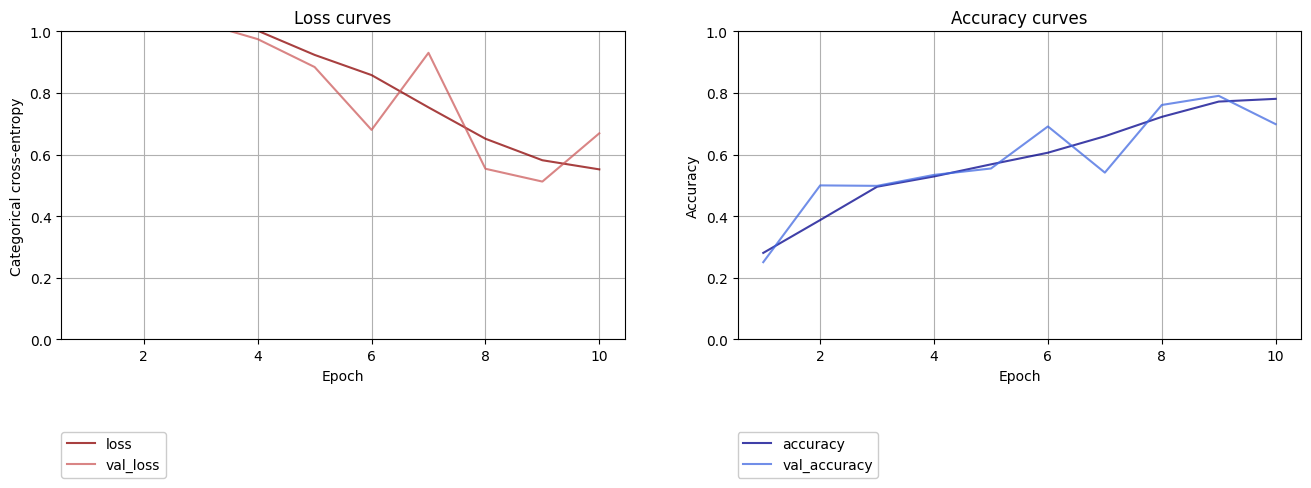

In [29]:
plot_training_history(history_modelv1_8)

#### **Hyperparameter Model**

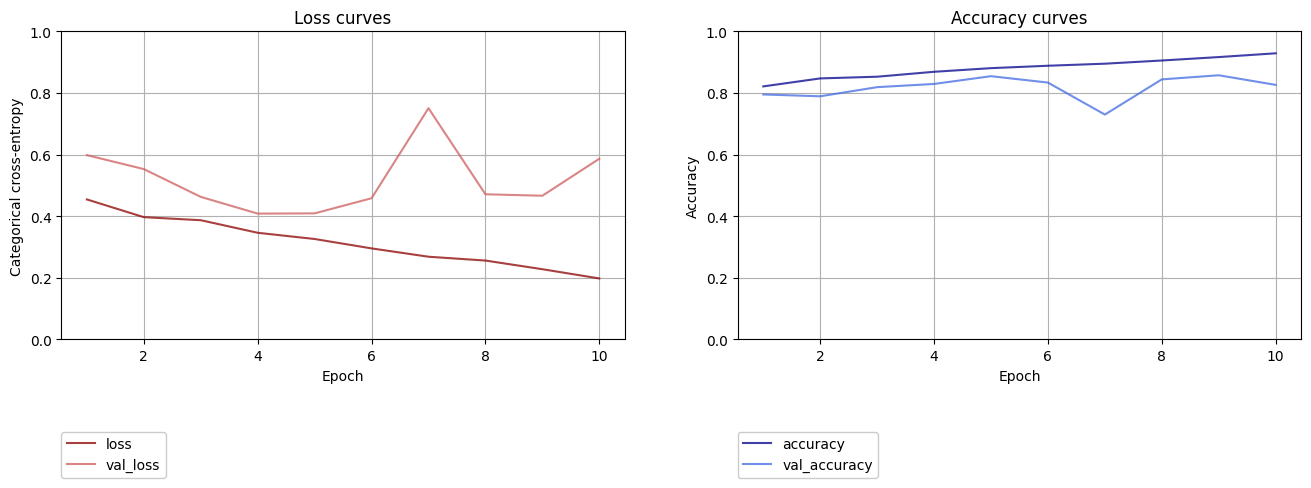

In [30]:
plot_training_history(history_best_model_v1_8_hp)

Unlike ``Model V1``, here, our **hyper tuned model** brought better results. The **accuracy** results are way higher with a value of 0.9289 for the **hyper tuned model**, and a value of 0.7810 for the **original model**. The **loss** also decreased significantly, from 0.5520 to 0.1979, which means that the results are being improved. 

However, one can not ignore the fact that they both present overfitting, which means both models are too tailored for our data.

## **Comparing ``Model V1`` and ``Model V1.8`` with ``Hypertuned Model V1`` and ``Hypertuned Model V1.8``** 






This table provides a comparison of the different models based on their accuracy, validation accuracy, loss, and validation loss:




Model Name   |  Accuracy  | Validation Accuracy | Loss     | Validation Loss
-------------|------------|---------------------|----------|----------------
**Model V1**     | 0.8418     | 0.8353              | 0.4067   | 0.4460 
**Model V1 HP**  | 0.7329     | 0.7537              | 0.5692   | 0.5431 
**Model V1.8**   | 0.7810     | 0.6988              | 0.5520   | 0.6691
**Model V1.8 HP**| 0.9289     | 0.8264              | 0.1979   | 0.5866 


For us to conclude, which is, our best model, one can not simply look at the accuracy values. By this standard, we would affirm that ``Model V1.8`` was better, with an accuracy of 0.9289, however, like we concluded earlier, this models suffers from severe overfitting.

Having this in mind, our choice for best model is ``Model V1``, since it has simultaneously high accuracy, 0.8418 and validation accuracy 0.8353, which are close results. This means that the model is ready to predict accurately on new and unseen data.


# **Performance on test dataset**
The final step is to evaluate the performance and generalization ability on the test dataset. Since the results on the previous steps were not very clarifying, we decided to perfom all the 4 best models on the test dataset.

## ModelV1


### `` modelv1`` , original model

In [31]:
scorev1 = modelv1.evaluate(ds_test, verbose=1)
print('Test loss:', scorev1[0])
print('Test accuracy:', scorev1[1])

14/14 [==============================] - 4s 102ms/step - loss: 0.5771 - accuracy: 0.7855
Test loss: 0.5770783424377441
Test accuracy: 0.7855450510978699


### `best_model_v1_hp`, hypertuned model

In [32]:
scorev1_hp = best_model_v1_hp.evaluate(ds_test, verbose=1)
print('Test loss:', scorev1_hp[0])
print('Test accuracy:', scorev1_hp[1])

14/14 [==============================] - 4s 115ms/step - loss: 0.6313 - accuracy: 0.7476
Test loss: 0.6313177943229675
Test accuracy: 0.7476303577423096


## ModelV1.8




### `` modelv1_8`` , original model

In [33]:
scorev1_8 = modelv1_8.evaluate(ds_test, verbose=1)
print('Test loss:', scorev1_8[0])
print('Test accuracy:', scorev1_8[1])

14/14 [==============================] - 5s 103ms/step - loss: 0.7370 - accuracy: 0.6848
Test loss: 0.7370048761367798
Test accuracy: 0.6848341226577759


### `best_model_v1_8_hp`, hypertuned model

In [34]:
scorev1_8_hp = best_model_v1_8_hp.evaluate(ds_test, verbose=1)
print('Test loss:', scorev1_8_hp[0])
print('Test accuracy:', scorev1_8_hp[1])

14/14 [==============================] - 4s 108ms/step - loss: 0.8002 - accuracy: 0.8081
Test loss: 0.8001816868782043
Test accuracy: 0.8080568909645081


# **Conclusion**

The following table presents the scores of the previous models in the test dataset:

Model Name   |  Test Accuracy  | Test Loss | 
-------------|-----------------|------|
**Model V1**     | 0.7855     | 0.5771                
**Model V1 HP**  | 0.7476     | 0.6313                 
**Model V1.8**   | 0.6848     | 0.7370                
**Model V1.8 HP**| 0.8081     | 0.8002          


Regarding the scores on the test dataset, it is important to look at both metrics, test accuracy and test loss.
Like mentioned in the above comparison analysis, ``Model V1.8 HP`` presents higher accuracy that ``Model V1``, but, due to the loss being higher, in fact, the higher of them all, these results strengthen the fact that ``Model V1`` is our best model.